In [1]:
from IPython.display import Image

# Model Training - Parameter Tuning

For model training, I am using GreatGameDota's script found at https://www.kaggle.com/greatgamedota/xception-classifier-w-ffhq-training-lb-537.

## Epochs, Factor, Learning Rates & Patience (IMPORTANT EXPERIMENTAL NOTES)

I've tried various learning rates `lr` (0.001, 0.0015, 0.002, 0.004), `epochs` (10, 12, 20, 42), `patience` (2, 5, 7) and `factor` (0.1, 0.2, 0.5, 0.7). The result from these is the score of 0.50480 for the Xception single model, and 0.43846 for the Resnext + Xception esemble. Further tweeking of these parameters do help increase the public LB score by a bit. Also, yet interestingly, as the score of the single model Xception decreases, the higher scoring esembles have equal weights, i.e. 0.5 for Resnext and 0.5 for Xception. 

Feel free to tweek these parameters further! Note that the total time for each run of 30 epochs or more on Google Cloud Compute took **more than 20 hours**. So it may be wise to plan your parameters properly based on the insights gathered from past trainings!

## Some Xception (Single Model) Training Outputs

In [4]:
!ls ../input/deepfake-kernel-data

google_cloud_compute_engine_launch_vm.png
google_cloud_vm.png
google_cloud_vm_deepfake_training_screenshot.png
lr_15e-2_epochs_42_patience_5.png
lr_2e-3_epochs_10_patience_5.png
lr_2e-3_epochs_20_patience_5.png
lr_4e-3_epochs_12_patience_2.png
lr_4e-3_epochs_30_patience_2.png
model_50epochs_lr0001_patience5_factor01_batchsize32.pth


### Learning Rate: 0.0015, Epochs: 42, Patience: 5

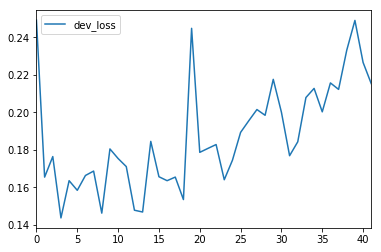

In [5]:
Image('../input/deepfake-kernel-data/lr_15e-2_epochs_42_patience_5.png')

### Learning Rate: 0.002, Epochs: 10, Patience: 5

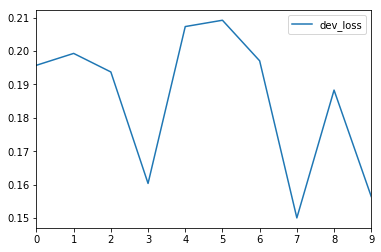

In [6]:
Image('../input/deepfake-kernel-data/lr_2e-3_epochs_10_patience_5.png')

### Learning Rate: 0.002, Epochs: 20, Patience: 5

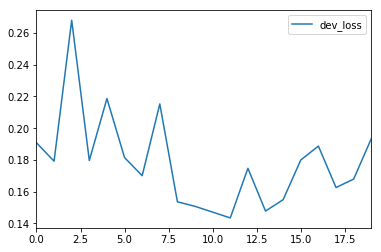

In [7]:
Image('../input/deepfake-kernel-data/lr_2e-3_epochs_20_patience_5.png')

### Learning Rate: 0.004, Epochs: 12, Patience: 2

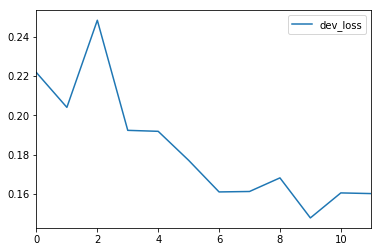

In [8]:
Image('../input/deepfake-kernel-data/lr_4e-3_epochs_12_patience_2.png')

### Learning Rate: 0.004, Epochs: 30, Patience: 2

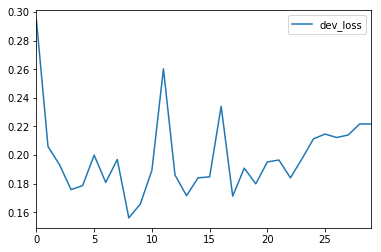

In [9]:
Image('../input/deepfake-kernel-data/lr_4e-3_epochs_30_patience_2.png')

## Some Training Outputs in the VM

Image('../input/deepfake-kernel-data/google_cloud_vm_deepfake_training_screenshot.png')

# Running the Instance in the Backend with Screen

To leave the VM instance running in the backend, you can use `screen`. For installation details and how to execute it, instructions can be found in the source link below, and at https://stackoverflow.com/questions/48221807/google-cloud-instance-terminate-after-close-browser.

Screen or GNU Screen is a terminal multiplexer. In other words, it means that you can start a screen session and then open any number of windows (virtual terminals) inside that session. Processes running in Screen will continue to run when their window is not visible even if you get disconnected.

**Source:** https://linuxize.com/post/how-to-use-linux-screen/

# Resnext & Xception Ensemble

- The following have been taken from https://www.kaggle.com/khoongweihao/xception-resnext-ensemble-inference

## Resnext Model

In [11]:
import os, sys, time
import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [12]:
test_dir = "/kaggle/input/deepfake-detection-challenge/test_videos/"

test_videos = sorted([x for x in os.listdir(test_dir) if x[-4:] == ".mp4"])
frame_h = 5
frame_l = 5
len(test_videos)

400

In [13]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.3.0
CUDA version: 10.0.130
cuDNN version: 7603


In [14]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [15]:
import sys
sys.path.insert(0, "/kaggle/input/blazeface-pytorch")
sys.path.insert(0, "/kaggle/input/deepfakes-inference-demo")

In [16]:
from blazeface import BlazeFace
facedet = BlazeFace().to(gpu)
facedet.load_weights("/kaggle/input/blazeface-pytorch/blazeface.pth")
facedet.load_anchors("/kaggle/input/blazeface-pytorch/anchors.npy")
_ = facedet.train(False)

In [17]:
from helpers.read_video_1 import VideoReader
from helpers.face_extract_1 import FaceExtractor

frames_per_video = 64 #frame_h * frame_l
video_reader = VideoReader()
video_read_fn = lambda x: video_reader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [18]:
input_size = 224

In [19]:
from torchvision.transforms import Normalize

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)

In [20]:
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

In [21]:
import torch.nn as nn
import torchvision.models as models

class MyResNeXt(models.resnet.ResNet):
    def __init__(self, training=True):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3], 
                                        groups=32, 
                                        width_per_group=4)
        self.fc = nn.Linear(2048, 1)

In [22]:
checkpoint = torch.load("/kaggle/input/deepfakes-inference-demo/resnext.pth", map_location=gpu)

model = MyResNeXt().to(gpu)
model.load_state_dict(checkpoint)
_ = model.eval()

del checkpoint

In [23]:
def predict_on_video(video_path, batch_size):
    try:
        # Find the faces for N frames in the video.
        faces = face_extractor.process_video(video_path)

        # Only look at one face per frame.
        face_extractor.keep_only_best_face(faces)
        
        if len(faces) > 0:
            # NOTE: When running on the CPU, the batch size must be fixed
            # or else memory usage will blow up. (Bug in PyTorch?)
            x = np.zeros((batch_size, input_size, input_size, 3), dtype=np.uint8)

            # If we found any faces, prepare them for the model.
            n = 0
            for frame_data in faces:
                for face in frame_data["faces"]:
                    # Resize to the model's required input size.
                    # We keep the aspect ratio intact and add zero
                    # padding if necessary.                    
                    resized_face = isotropically_resize_image(face, input_size)
                    resized_face = make_square_image(resized_face)

                    if n < batch_size:
                        x[n] = resized_face
                        n += 1
                    else:
                        print("WARNING: have %d faces but batch size is %d" % (n, batch_size))
                    
                    # Test time augmentation: horizontal flips.
                    # TODO: not sure yet if this helps or not
                    #x[n] = cv2.flip(resized_face, 1)
                    #n += 1

            if n > 0:
                x = torch.tensor(x, device=gpu).float()

                # Preprocess the images.
                x = x.permute((0, 3, 1, 2))

                for i in range(len(x)):
                    x[i] = normalize_transform(x[i] / 255.)

                # Make a prediction, then take the average.
                with torch.no_grad():
                    y_pred = model(x)
                    y_pred = torch.sigmoid(y_pred.squeeze())
                    return y_pred[:n].mean().item()

    except Exception as e:
        print("Prediction error on video %s: %s" % (video_path, str(e)))

    return 0.5

In [24]:
from concurrent.futures import ThreadPoolExecutor

def predict_on_video_set(videos, num_workers):
    def process_file(i):
        filename = videos[i]
        y_pred = predict_on_video(os.path.join(test_dir, filename), batch_size=frames_per_video)
        return y_pred

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        predictions = ex.map(process_file, range(len(videos)))

    return list(predictions)

In [25]:
speed_test = False  # you have to enable this manually

In [26]:
if speed_test:
    start_time = time.time()
    speedtest_videos = test_videos[:5]
    predictions = predict_on_video_set(speedtest_videos, num_workers=4)
    elapsed = time.time() - start_time
    print("Elapsed %f sec. Average per video: %f sec." % (elapsed, elapsed / len(speedtest_videos)))

In [27]:
predictions = predict_on_video_set(test_videos, num_workers=4)

In [28]:
submission_df_resnext = pd.DataFrame({"filename": test_videos, "label": predictions})
submission_df_resnext.to_csv("submission_resnext.csv", index=False)

## Xception Model

In [29]:
!pip install ../input/deepfake-xception-trained-model/pytorchcv-0.0.55-py2.py3-none-any.whl --quiet

In [30]:
test_dir = "/kaggle/input/deepfake-detection-challenge/test_videos/"

test_videos = sorted([x for x in os.listdir(test_dir) if x[-4:] == ".mp4"])
len(test_videos)

400

In [31]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [32]:
import sys
sys.path.insert(0, "/kaggle/input/blazeface-pytorch")
sys.path.insert(0, "/kaggle/input/deepfakes-inference-demo")

In [33]:
from blazeface import BlazeFace
facedet = BlazeFace().to(gpu)
facedet.load_weights("/kaggle/input/blazeface-pytorch/blazeface.pth")
facedet.load_anchors("/kaggle/input/blazeface-pytorch/anchors.npy")
_ = facedet.train(False)

In [34]:
from helpers.read_video_1 import VideoReader
from helpers.face_extract_1 import FaceExtractor

frames_per_video = 64 # originally 4

video_reader = VideoReader()
video_read_fn = lambda x: video_reader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [35]:
input_size = 150

In [36]:
from torchvision.transforms import Normalize

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)

In [37]:
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

In [38]:
!ls ../input/deepfake-xception-trained-model

model.pth     model_v2.1.pth  pytorchcv-0.0.55-py2.py3-none-any.whl
model_v0.pth  model_v2.pth
model_v1.pth  model_v3.pth


In [39]:
!ls ../input/deepfake-kernel-data

google_cloud_compute_engine_launch_vm.png
google_cloud_vm.png
google_cloud_vm_deepfake_training_screenshot.png
lr_15e-2_epochs_42_patience_5.png
lr_2e-3_epochs_10_patience_5.png
lr_2e-3_epochs_20_patience_5.png
lr_4e-3_epochs_12_patience_2.png
lr_4e-3_epochs_30_patience_2.png
model_50epochs_lr0001_patience5_factor01_batchsize32.pth


In [40]:
from pytorchcv.model_provider import get_model
model = get_model("xception", pretrained=False)
model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer

class Pooling(nn.Module):
  def __init__(self):
    super(Pooling, self).__init__()
    
    self.p1 = nn.AdaptiveAvgPool2d((1,1))
    self.p2 = nn.AdaptiveMaxPool2d((1,1))

  def forward(self, x):
    x1 = self.p1(x)
    x2 = self.p2(x)
    return (x1+x2) * 0.5

model[0].final_block.pool = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)))

class Head(torch.nn.Module):
  def __init__(self, in_f, out_f):
    super(Head, self).__init__()
    
    self.f = nn.Flatten()
    self.l = nn.Linear(in_f, 512)
    self.d = nn.Dropout(0.5)
    self.o = nn.Linear(512, out_f)
    self.b1 = nn.BatchNorm1d(in_f)
    self.b2 = nn.BatchNorm1d(512)
    self.r = nn.ReLU()

  def forward(self, x):
    x = self.f(x)
    x = self.b1(x)
    x = self.d(x)

    x = self.l(x)
    x = self.r(x)
    x = self.b2(x)
    x = self.d(x)

    out = self.o(x)
    return out

class FCN(torch.nn.Module):
  def __init__(self, base, in_f):
    super(FCN, self).__init__()
    self.base = base
    self.h1 = Head(in_f, 1)
  
  def forward(self, x):
    x = self.base(x)
    return self.h1(x)

net = []
model = FCN(model, 2048)
model = model.cuda()
model.load_state_dict(torch.load('../input/deepfake-kernel-data/model_50epochs_lr0001_patience5_factor01_batchsize32.pth')) # new, updated
net.append(model)

### Prediction Loop

In [41]:
def predict_on_video(video_path, batch_size):
    try:
        # Find the faces for N frames in the video.
        faces = face_extractor.process_video(video_path)

        # Only look at one face per frame.
        face_extractor.keep_only_best_face(faces)
        
        if len(faces) > 0:
            # NOTE: When running on the CPU, the batch size must be fixed
            # or else memory usage will blow up. (Bug in PyTorch?)
            x = np.zeros((batch_size, input_size, input_size, 3), dtype=np.uint8)

            # If we found any faces, prepare them for the model.
            n = 0
            for frame_data in faces:
                for face in frame_data["faces"]:
                    # Resize to the model's required input size.
                    # We keep the aspect ratio intact and add zero
                    # padding if necessary.                    
                    resized_face = isotropically_resize_image(face, input_size)
                    resized_face = make_square_image(resized_face)

                    if n < batch_size:
                        x[n] = resized_face
                        n += 1
                    else:
                        print("WARNING: have %d faces but batch size is %d" % (n, batch_size))
                    
                    # Test time augmentation: horizontal flips.
                    # TODO: not sure yet if this helps or not
                    #x[n] = cv2.flip(resized_face, 1)
                    #n += 1

            if n > 0:
                x = torch.tensor(x, device=gpu).float()

                # Preprocess the images.
                x = x.permute((0, 3, 1, 2))

                for i in range(len(x)):
                    x[i] = normalize_transform(x[i] / 255.)
#                     x[i] = x[i] / 255.

                # Make a prediction, then take the average.
                with torch.no_grad():
                    y_pred = model(x)
                    y_pred = torch.sigmoid(y_pred.squeeze())
                    return y_pred[:n].mean().item()

    except Exception as e:
        print("Prediction error on video %s: %s" % (video_path, str(e)))

    return 0.5

In [42]:
from concurrent.futures import ThreadPoolExecutor

def predict_on_video_set(videos, num_workers):
    def process_file(i):
        filename = videos[i]
        y_pred = predict_on_video(os.path.join(test_dir, filename), batch_size=frames_per_video)
        return y_pred

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        predictions = ex.map(process_file, range(len(videos)))

    return list(predictions)

In [43]:
speed_test = False

In [44]:
if speed_test:
    start_time = time.time()
    speedtest_videos = test_videos[:5]
    predictions = predict_on_video_set(speedtest_videos, num_workers=4)
    elapsed = time.time() - start_time
    print("Elapsed %f sec. Average per video: %f sec." % (elapsed, elapsed / len(speedtest_videos)))

In [45]:
%%time
model.eval()
predictions = predict_on_video_set(test_videos, num_workers=4)

CPU times: user 48min 22s, sys: 1min 43s, total: 50min 6s
Wall time: 26min 12s


In [46]:
submission_df_xception = pd.DataFrame({"filename": test_videos, "label": predictions})
submission_df_xception.to_csv("submission_xception.csv", index=False)

In [47]:
submission_df_resnext.head()

,filename,label
0,aassnaulhq.mp4,0.514175
1,aayfryxljh.mp4,0.004443
2,acazlolrpz.mp4,0.725788
3,adohdulfwb.mp4,0.060911
4,ahjnxtiamx.mp4,0.880215


In [48]:
submission_df_xception.head()

,filename,label
0,aassnaulhq.mp4,0.971394
1,aayfryxljh.mp4,0.009612
2,acazlolrpz.mp4,0.871579
3,adohdulfwb.mp4,0.005191
4,ahjnxtiamx.mp4,0.748403


## Ensemble of Resnext & Xception

- Resnext single model public score: 0.46441
- Xception single model public score: 0.50480

In [49]:
submission_df = pd.DataFrame({"filename": test_videos})
submission_df["label"] = 0.5*submission_df_resnext["label"] + 0.5*submission_df_xception["label"]

In [50]:
submission_df.to_csv("submission.csv", index=False)